# Parcours de Graphes

Ce document vise Ã  illustrer les algorithmes classiques de parcours de graphes

## Graphe

Un graphe est un objet mathÃ©matique constituÃ© de :

* un ensemble $V$ de sommets
* un ensemble $E \subset V \times V$ d'arÃªtes reliant ces sommets

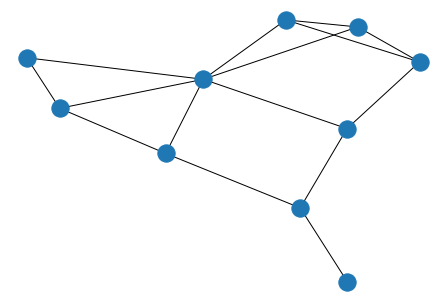

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.gnp_random_graph(10, 0.4)
nx.draw(G)

Ici les sommets sont les points bleus, et les arÃªtes sont les lignes qui les relient. On distingue les **graphes non orientÃ©s**, pour lesquels les arÃªtes n'ont pas de notion de direction, et les **graphes orientÃ©s**, pour lesquels l'arÃªte de u Ã  v n'est pas la mÃªme que l'arÃªte de v Ã  u. En terme de terminologie, on utilise souvent le terme *arc* plutÃ´t qu'arÃªte pour le cas non orientÃ©.

Les graphes permettent de modÃ©liser de trÃ¨s nombreux problÃ¨mes, et se prÃªtent Ã©galement bien Ã  l'Ã©tude des structures de donnÃ©es. Une liste chaÃ®nÃ©e par exemple peut Ãªtre vue comme un graphe oÃ¹ les sommets sont les cellules et les arÃªtes sont les liens des cellules vers leurs suivantes. Plus gÃ©nÃ©ralement toute structure de donnÃ©e ou des petits blocs de mÃ©moire sont liÃ©s les uns aux autres par des adresses ou des rÃ©fÃ©rences se prÃªte bien Ã  ce formalisme.

Le code qui suit vise Ã  gÃ©nÃ©rer des graphes et les animer, il n'est pas important pour la comprÃ©hension de la suite.

In [2]:
# Cliquer Ã  gauche pour voir ou masquer le code

import matplotlib.animation
from IPython.display import HTML
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
import shapely.geometry as geom
import math
import random

def animate_graph(G, positions, animation, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.close()
        
    def update(frame):
        ax.clear()
        
        nx.draw(G, pos=positions, ax=ax, node_size=200, node_color = animation['colors'][frame], width = animation['widths'][frame], **kwargs)
                
    ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(animation['colors']), interval=80, repeat=True)
    return HTML(ani.to_html5_video())

def disk_lloyd(pts):
    new_pts = []
    vor = Voronoi(pts)
    disk = geom.Point(0,0).buffer(1.0)
    for i in range(len(pts)):
        pt = pts[i]
        r = vor.regions[vor.point_region[i]]
        if -1 not in r:
            p = geom.Polygon([vor.vertices[k] for k in r]).intersection(disk)
            new_pts.append(p.centroid.coords[:][0])
        else:
            new_pts.append(pt)
    return new_pts

def gen_in_disk(size):
    #https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly
    pts = []
    for i in range(size):
        t = 2*math.pi*random.random()
        u = random.random()+random.random()
        if u>1:
            r = 2-u 
        else:
            r = u
        pts.append((r*math.cos(t), r*math.sin(t)))
    #smooth
    for i in range(20):
        pts = disk_lloyd(pts)
    return pts
        
def delaunay_graph(pts):
    G = nx.Graph()
    delaunay = Delaunay(pts)
    for s in delaunay.simplices:
        for i in range(3):
            v0 = s[i]
            v1 = s[(i+1)%3]
            G.add_edge(v0,v1)
    for i, n in enumerate(G.nodes):
        G.nodes[n]['index'] = i
    for i,e in enumerate(G.edges):
        G.edges[e]['index'] = i
    return G

def leftmost(g, pts):
    lm = 0
    xlm = pts[lm][0]
    for n in G.nodes:
        xn = pts[n][0]
        if xn < xlm:
            lm = n
            xlm = xn
    return lm

def rightmost(g, pts):
    lm = 0
    xlm = pts[lm][0]
    for n in G.nodes:
        xn = pts[n][0]
        if xn > xlm:
            lm = n
            xlm = xn
    return lm

class animated_container:
    
    def __init__(self, G):
        self.init_color = "gray"
        self.pushed_color = "cornflowerblue"
        self.popped_color = "darkorange"
        self.current_color = "gold"
    
        self.init_width = 1
        self.used_width = 5
        
        self.colors = [self.init_color for n in G.nodes]
        self.widths = [self.init_width for e in G.edges]
        
        self.animation = {'colors':[], 'widths':[]}
        self.pop_steps = []
        self.current = None
        
        self.graph = G
        
    def append_animation(self):
        colors = self.colors[:]
        if self.current != None:
            colors[self.current] = self.current_color
        self.animation['colors'].append(colors)
        self.animation['widths'].append(self.widths[:])
        
    def push(self,v,u = None):
        self.colors[self.graph.nodes[v]['index']] = self.pushed_color
        if u != None:
            self.widths[self.graph[u][v]['index']] = self.used_width
        self.append_animation()
        
    def pop(self,u):
        self.colors[self.graph.nodes[u]['index']] = self.popped_color
        self.append_animation()
        self.pop_steps.append(self.graph.nodes.data())
    
    def top(self,v):
        self.current = self.graph.nodes[v]['index']
    
    def empty(self):
        return 

Nous pouvons maintenant gÃ©nÃ©rer alÃ©atoirement des graphes permettant d'illustrer facilement les parcours, car leurs arÃªtes ne partent pas dans tous les sens.

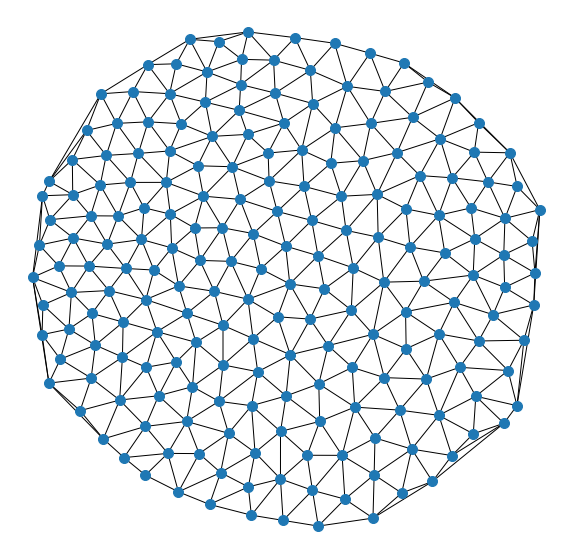

In [3]:
pts = gen_in_disk(200)
G = delaunay_graph(pts)
plt.subplots(figsize=(10,10))
nx.draw(G, pos=pts, node_size = 100)

## Traverser un graphe

Le principe de la traversÃ©e d'un graphe consiste Ã  partir d'un sommet et Ã©tendre le parcours Ã  ses voisins. Il est donc nÃ©cessaire de :

* maintenir un ensemble des sommets Ã  traiter
* pouvoir dÃ©terminer si un sommet a dÃ©jÃ  Ã©tÃ© rencontrÃ©

Initialement, seul le sommet de dÃ©part a Ã©tÃ© rencontrÃ© et a Ã©tÃ© traitÃ©. On distingue :

* le parcours en profondeur qui utilise une **pile** pour l'ensemble des sommets Ã  traiter
* le parcours en largeur qui utilise une **file** pour l'ensemble des sommets Ã  traiter

Ã€ part cette diffÃ©rence de gestion des sommets Ã  traiter l'algorithme de parcours est le mÃªme. De maniÃ¨re gÃ©nÃ©rique nous pouvons le coder comme suit.

In [4]:
# G est le graphe
# start le sommet de dÃ©part
# s la structure de donnÃ©es Ã  utiliser pour stocker les sommets Ã  traiter

def traverse(G, start, s):    
    # initialement, aucun sommet n'est traitÃ©
    for n in G.nodes:
        G.nodes[n]['visited'] = False
    
    # on ajoute le sommet de dÃ©part aux sommets Ã  traiter
    s.push(start)
    # on le marque comme vu
    G.nodes[start]['visited'] = True
    
    #tant qu'il reste des sommets Ã  traiter
    while not s.empty():
        # rÃ©cupÃ©rer un sommet Ã  traiter
        t = s.top()
        # si ce sommet a un voisin non vu
        finished = True
        for n in G.neighbors(t):
            if not G.nodes[n]['visited']:
                # marquer le voisin comme vu
                G.nodes[n]['visited'] = True
                # l'ajouter aux sommets Ã  traiter
                s.push(n, t)
                # indiquer qu'un voisin inconnu a Ã©tÃ© rencontrÃ©
                finished = False
                break
        # lorsqu'aucun voisin n'Ã©tait inconnu
        if finished:
            # retirer le sommet de l'ensemble des sommets Ã  traiter
            s.pop()

### Parcours en profondeur Ã  l'aide d'une pile

In [5]:
# ImplÃ©mentation d'une pile

class stack(animated_container):
    
    def __init__(self, G):
        super().__init__(G)
        
        # la pile est implÃ©mentÃ©e dans un tableau
        self.data = []
        
    def push(self,v,u = None):
        super().push(v, u)
        
        # l'insertion se fait en fin de tableau
        self.data.append(v)
        
    def pop(self):
        u = self.top()
        super().pop(u)
        
        # le retrait se fait en fin de tableau
        self.data.pop()
        
    def top(self):
        # le sommet de la pile est en fin de tableau
        t = self.data[-1]
        super().top(t)
        return t
    
    def empty(self):
        super().empty()
        return len(self.data) == 0

En utilisant une pile, la politique "last in first out" (LIFO) fait que l'algorithme cherche Ã  avancer le plus possible sans attendre d'avoir fini d'Ã©tudier intÃ©gralement les voisins d'un sommet.

In [6]:
begin = leftmost(G, pts)
s = stack(G)
traverse(G, begin, s)

In [7]:
animate_graph(G, pts, s.animation)

Le parcours en profondeur s'exprime beaucoup plus naturellement de faÃ§on rÃ©cursive. Dans cette version, la pile semble avoir disparue, mais c'est la pile d'appels de fonction qui sert de pile pour les calculs.

In [8]:
def recursive_descent(G, v):
    #Pour chaque sommet voisin
    for n in G.neighbors(v):
        #si le sommet est inconnu
        if not G.nodes[n]['visited']:
            #le visiter
            G.nodes[n]['visited'] = True
            #lancer immÃ©diatement son exploration
            recursive_descent(G,n)

def traverse_profondeur(G, start):    
    # initialement, aucun sommet n'est traitÃ©
    for n in G.nodes:
        G.nodes[n]['visited'] = False
    
    #visite du sommet initial
    G.nodes[start]['visited'] = True
    #lancement de la rÃ©cursion
    recursive_descent(G,start)

In [9]:
traverse_profondeur(G, begin)

#vÃ©rification que tous les sommets sont visitÃ©s
for n in G.nodes:
    if not G.nodes[n]['visited']:
        print("a node was missed")

### Parcours en largeur Ã  l'aide d'une file

In [10]:
#ImplÃ©mentation naÃ¯ve d'une file

class queue(animated_container):
    
    def __init__(self, G):
        super().__init__(G)
        
        #les donnÃ©es sont stockÃ©es dans un tableau
        self.data = []
        
    def push(self,v,u = None):
        super().push(v, u)
        #l'insertion est faite en fin de tableau
        self.data.append(v)
        
    def pop(self):
        u = self.top()
        super().pop(u)
        #ouch, la complexitÃ© de la suite est mauvaise
        #recopier tout le tableau sans son premier Ã©lÃ©ment
        #le retrait Ã  donc lieu au dÃ©but
        self.data = self.data[1:]
        
    def top(self):
        #le sommet de la file est au dÃ©but du tableau
        t = self.data[0]
        super().top(t)
        return t
    
    def empty(self):
        super().empty()
        return len(self.data) == 0

En utilisant une file, la politique "first in first out" (FIFO) assure que les sommets sont traitÃ©s par ordre de dÃ©couverte, et qu'on traite intÃ©gralement tous les voisins d'un sommet avant de passer au suivant.

In [11]:
q = queue(G)
traverse(G, begin, q)

In [12]:
animate_graph(G, pts, q.animation)

Le parcours en largeur est en particulier utile pour dÃ©terminer le plus court chemin en terme de nombre d'arÃªtes pour aller du sommet de dÃ©part Ã  n'importe quelle autre. Dans la mesure oÃ¹ le parcours traite intÃ©gralement chaque sommet avant de passer au suivant, on peut rÃ©Ã©crire plus simplement le parcours :

In [13]:
def traverse_largeur(G, start):    
    q = queue(G)
    
    # initialement, aucun sommet n'est traitÃ©
    for n in G.nodes:
        G.nodes[n]['visited'] = False
    
    # on ajoute le sommet de dÃ©part aux sommets Ã  traiter
    q.push(start)
    # on le marque comme vu
    G.nodes[start]['visited'] = True
    
    #tant qu'il reste des sommets Ã  traiter
    while not q.empty():
        # rÃ©cupÃ©rer un sommet Ã  traiter
        t = q.top()
        for n in G.neighbors(t):
            if not G.nodes[n]['visited']:
                # marquer le voisin comme vu
                G.nodes[n]['visited'] = True
                # l'ajouter aux sommets Ã  traiter
                q.push(n, t)
        # le sommet est dÃ©sormais traitÃ©, on peut le relÃ¢cher
        q.pop()

In [14]:
traverse_largeur(G, begin)

#vÃ©rification que tous les sommets sont visitÃ©s
for n in G.nodes:
    if not G.nodes[n]['visited']:
        print("a node was missed")

## Algorithme de Dijkstra

L'algorithme de Dijkstra gÃ©nÃ©ralise le parcours en largeur pour dÃ©terminer les plus courts chemins Ã  partir d'un sommet de dÃ©part vers tous les autres sommets du graphe dans un graphe aux arÃªtes pondÃ©rÃ©es. PondÃ©rer les arÃªtes d'un graphe consiste Ã  ajouter sur chaque arÃªte un coÃ»t pour l'emprunter. Dans le cas oÃ¹ les arÃªtes ont toutes le mÃªme coÃ»t, l'algorithme de Dijkstra dÃ©gÃ©nÃ¨re en parcours en largeur.

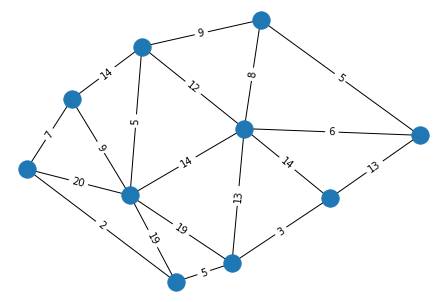

In [15]:
Hpts = gen_in_disk(10)
H = delaunay_graph(Hpts)
for u,v in H.edges:
    H[u][v]['weight'] = random.randint(1,20)

nx.draw(H, Hpts)
#_ = nx.draw_networkx_labels(H, Hpts, font_color="white")
_ = nx.draw_networkx_edge_labels(H, Hpts, edge_labels = nx.get_edge_attributes(H, 'weight'))

**Attention** : pour que la notion mÃªme de plus court chemin existe, dans un graphe non orientÃ©, il est nÃ©cessaire que les coÃ»ts des arcs soient tous positifs. Sinon, en faisant des allers-retours entre deux sommets reliÃ©s par un arc de coÃ»t nÃ©gatif, on peut diminuer infiniment le coÃ»t d'un chemin. Dans le cas d'un graphe orientÃ©, il faut qu'il n'y ait pas de *cycles* de coÃ»t total nÃ©gatif. Notez Ã©galement que dans ce dernier cas, l'algorithme de Dijkstra n'est pas forcÃ©ment le plus adaptÃ©, car sa complexitÃ© peut dÃ©gÃ©nrer dans le pire cas. On peut alors lui prÃ©fÃ©rer l'algorithme de Bellman-Ford qui sera meilleur dans le pire cas, qui a en particulier l'avantage de ne pas partir en boucle infinie en cas de cycle nÃ©gatif et permet de les dÃ©tecter.

L'algorithme de Dijkstra utilise une file a prioritÃ©. Le principe d'une telle file est qu'on y insÃ¨re des Ã©lÃ©ments avec une prioritÃ©. La file a prioritÃ© permet ensuite facilement :
* d'insÃ©rer de nouveaux Ã©lÃ©ments munis d'une prioritÃ©
* de dÃ©terminer l'Ã©lÃ©ment actuellement de plus forte prioritÃ©
* de retirer cet Ã©lÃ©ment

Pour l'algorithme de Dijkstra le principe est de calculer et mettre Ã  jour en permanence la distance des sommets par rapport au sommet de dÃ©part. Cette distance dÃ©terminer la prioritÃ© d'un sommet. Plus cette distance est faible, plus le noeud est traitÃ© rapidement. Un code naÃ¯f est fourni ci-dessous pour gÃ©rer une file a prioritÃ©, mais ce code est mauvais en terme de complexitÃ© car chaque insertion parcourt linÃ©airement tous les Ã©lÃ©ments de la file. Il serait possible de faire mieux avec des structures vues cette annÃ©e, comme un arbre binaire de recherche, une skip-list ou un tas par exemple. Dans la librairie standard du c++, il existe un conteneur `priority_queue` qui utilise un tas binaire.

In [16]:
class pqueue(animated_container):
    def __init__(self,G):
        super().__init__(G)
        
        self.data = []    
        self.graph = G        
            
    #insertion non efficace
    def _insert_sort(self, d, v):
        self.data.append(None)
        i = len(self.data) - 2
        while i >=0 and self.data[i][0] < d:
            self.data[i+1] = self.data[i]
            i = i-1
        self.data[i+1] = (d,v)
                
    def push(self,v,d,u = None):
        p = self.graph.nodes[v]['parent']
        if p is not None:
            self.widths[self.graph[p][v]['index']] = self.init_width
        self._insert_sort(d, v)
        super().push(v,u)

        
    def pop(self):
        u = self.top()
        super().pop(u)
        self.data.pop()
        
    def top(self):
        t = self.data[-1]
        super().top(t[1])
        return t[1]
    
    def empty(self):
        super().empty()
        return len(self.data) == 0

Le dÃ©roulÃ© de l'algorithme de Dijkstra est souvent reprÃ©sentÃ© par une table. Le code ci-dessous permet une gÃ©nÃ©rer de telle table. Chaque ligne de la table reprÃ©sente une itÃ©ration de l'algorithme, et donne pour chaque sommet du graphe la distance actuellement connue depuis le sommet de dÃ©part, ainsi que le prÃ©dÃ©cesseur du noeud sur le chemin depuis le sommet de dÃ©part rÃ©alisant cette distance. Par exemple si le sommet de dÃ©part est le sommet 0 et si pour le sommet 3 on a une distance 5 via un chemin 0 â†’ 5 â†’ 8 â†’ 3 alors dans la colonne du sommet 3 de la table, on aura 5 comme distance et 8 comme prÃ©dÃ©cesseur. Dans le code ci-dessous, on verra dans chaque case de la table un couple (distance, prÃ©dÃ©cesseur).

In [17]:
from IPython.display import display, Markdown


class DijkstraTable:
    
    def __init__(self,G):
        self.G = G
        self.str = "|" + "|".join(["%d" % i for i in range(len(G.nodes))]) + "|\n"
        self.str = self.str + "|" + "|".join(["---" for n in G.nodes]) + "|\n"
        

    def step(self, active_node):
        line = ["" for n in G.nodes]
        for n in self.G.nodes:
            d = self.G.nodes[n]['distance']
            p = self.G.nodes[n]['parent']
            if d is None:
                line[n] = "X,X"
            else:
                if n == active_node:
                    line[n] = "**%d,%d**" % (d,p)
                else:
                    line[n] = "%d,%d" % (d,p)
        self.str = self.str + "|" + "|".join(line) + "|\n"
    
    def show(self):
        display(Markdown(self.str))

L'algorithme en lui-mÃªme reprend la structure d'un parcours en largeur. Notez ici que les sommets sont systÃ©matiquement ajoutÃ©s Ã  la file Ã  prioritÃ© dÃ¨s qu'on a une distance plus courte que la distance connue, ce qui fait qu'on aura potentiellement plusieurs fois le mÃªme sommet dans la file. Ce n'est pas un problÃ¨me, car **Dijkstra de fait jamais augmenter la distance Ã  un sommet**. Du coup, si la distance d'un sommet change, c'est qu'elle devient plus petite, et donc que la nouvelle version insÃ©rÃ©e du sommet sortira de la file avant la version plus ancienne qui a une distance plus grande. Si la structure de file le permet, il est plus judicieux de modifier la prioritÃ© de l'Ã©lÃ©ment prÃ©sent dedans. Un tas binaire ne permet pas efficacement de modifier les prioritÃ©s. Un arbre binaire de recherche ou une skip-list en seraient capables. Il existe Ã©galement les *pairing heaps* ou les *fibonacci heaps* qui permettent de rÃ©aliser cette opÃ©ration efficacement.

In [18]:
def dijkstra(G, start, s):    

    for n in G.nodes:
        G.nodes[n]['distance'] = None
        G.nodes[n]['parent'] = None
        
    table = DijkstraTable(G)
    
    s.push(start, 0)
    G.nodes[start]['distance'] = 0
    G.nodes[start]['parent'] = start
    
    while not s.empty():
        u = s.top()
        s.pop()
        table.step(u)
        du = G.nodes[u]['distance']
        for v in G.neighbors(u):
            dv = G.nodes[v]['distance']
            duv = du + G[u][v]['weight']
            if dv is None or duv < dv:
                G.nodes[v]['distance'] = duv
                G.nodes[v]['parent'] = u
                s.push(v, duv, u) #normalement ici si le noeud est dÃ©jÃ  dans la file on le modifie

    return table

In [19]:
pq = pqueue(H)
table = dijkstra(H, 0, pq)
table.show()

|0|1|2|3|4|5|6|7|8|9|
|---|---|---|---|---|---|---|---|---|---|
|**0,0**|X,X|X,X|X,X|X,X|X,X|X,X|X,X|X,X|X,X|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|X,X|X,X|X,X|**5,0**|X,X|X,X|13,0|X,X|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|**6,0**|X,X|X,X|X,X|5,0|X,X|X,X|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|20,1|X,X|X,X|5,0|19,1|X,X|**13,0**|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|20,1|X,X|X,X|5,0|16,8|X,X|13,0|**14,5**|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|X,X|28,9|5,0|**16,8**|X,X|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|**19,9**|X,X|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|39,2|28,9|5,0|**16,8**|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|**19,9**|39,2|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|39,2|28,9|5,0|16,8|**21,6**|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|**23,7**|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|23,7|**28,9**|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|0,0|6,0|19,9|**23,7**|28,9|5,0|16,8|21,6|13,0|14,5|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


Cette table montre les itÃ©rations de l'algorithme sur le graphe prÃ©cÃ©dent. 

Pour illustrer graphiquement ce parcours, nous allons assigner Ã  chaque sommet des altitudes pour faire des montagnes

In [20]:
def mountains(x, y):
    def g(cx, cy, x, y):
        xd = x - cx
        yd = y - cy
        return np.exp(-(xd*xd + yd*yd) / 0.2)
                      
    return 100 * (g(0.5,0.5,x,y) + g(-0.5, -0.2, x, y) + g(-0.2, 0.6, x, y) + g(0.5, -0.4, x, y))

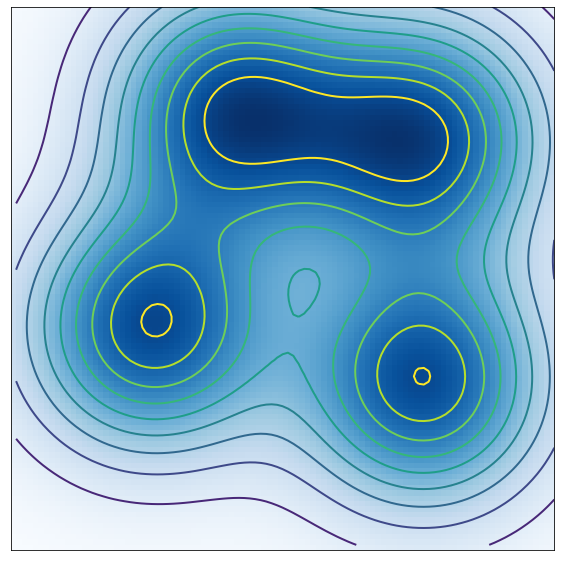

In [21]:
import numpy as np

x = np.arange(-1.0,1.0,0.02)
y = np.arange(-1.0,1.0,0.02)
X,Y = np.meshgrid(x, y)
Z = mountains(X, Y)

min_val = np.min(Z)
max_val = np.max(Z)
spacing = (max_val - min_val) / 10

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])
im = plt.imshow(Z,cmap=plt.cm.Blues, origin='lower')
cset = plt.contour(Z,np.arange(min_val, max_val, spacing),linewidths=2, origin='lower')
plt.show()

ensuite, pour calculer la distance entre deux noeuds, nous utiliserons la distance euclidienne entre les positions des deux sommets du graphe, altitude comprise. Du coup le dÃ©nivelÃ© est pris en compte, et plus la diffÃ©rence d'altitude entre deux sommets est importante, plus il sera coÃ»teux d'emprunter l'arÃªte qui les relie. ENd essous, la couleur des sommets est d'autant plus sombre que le noeud a une altitude Ã©levÃ©e, et une arÃªte est d'autant plus sombre que son poids est important.

In [22]:
def distance(p0, p1):
    d = 0
    for (c0,c1) in zip(p0, p1):
        d += (c0 - c1)*(c0 - c1)
    return math.sqrt(d)

for u,v in G.edges:
    p0 = pts[u]
    p1 = pts[v]
    h0 = mountains(*p0)
    h1 = mountains(*p1)
    G[u][v]['weight'] = distance([*p0, h0], [*p1, h1])

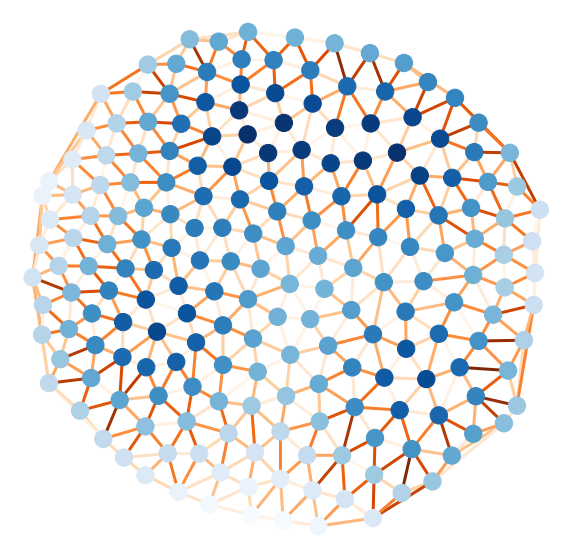

In [23]:
fig = plt.subplots(figsize=(10,10))
ec = [G[u][v]['weight'] for u,v in G.edges]
nc = [mountains(*pts[n]) for n in G.nodes]
nx.draw(G, pos=pts, edge_color=ec, node_color=nc, cmap=plt.cm.Blues, edge_cmap=plt.cm.Oranges, width=3)

In [24]:
pq = pqueue(G)
table = dijkstra(G, begin, pq)
# table.show() # la table est trop grosse pour Ãªtre lisible

In [25]:
animate_graph(G, pts, pq.animation)

## Algorithme A*

L'algorithme de Dijkstra cherche les plus courts chemins d'un sommet du graphe vers tous les autres. Souvent, vous ne cherchez pas le chemin vers tous les autres sommets du graphe, mais simplement vers un sommet en particuler. Dans ce cas, Dijkstra vous donnera le bon rÃ©sultat, mais fera plus de travail que nÃ©cessaire. Dans le cas oÃ¹ vous ne cherchez le plus court chemin que vers un sommet particulier, une premiÃ¨re option consiste Ã  interrompre l'algorithme de Dijkstra au moment oÃ¹ le sommet d'arrivÃ©e est traitÃ©, c'est Ã  dire quand il sort de la file. L'algorithme A* permet Ã©ventuellement de faire mieux. 

Pour pouvoir le mettre en Å“uvre, il est nÃ©cessaire d'avoir une fonction qui Ã©tant donnÃ© deux sommets quelconques du graphe, renvoie une approximation de la distance pour aller de l'un Ã  l'autre. De plus, pour garantir que le rÃ©sultat de A* est correct, il est nÃ©cessaire que cette approximation soit toujours plus faible que la vraie distance. Dans notre exemple de graphe montagneux, on peut facilement dÃ©finir une telle approximation en utilisant la distance Ã  vol d'oiseau : la ligne droite sera toujours plus courte que le chemin passant par les sommets du graphe, et qui a de grande chance de faire quelques zig-zags.

In [26]:
def approx(G, pts, v, end):
    p0 = pts[v]
    p1 = pts[end]
    h0 = mountains(*p0)
    h1 = mountains(*p1)
    return distance([*p0, h0], [*p1, h1])

L'algorithme A* est ensuite une toute petite variation de l'algorithme de Dijkstra, qui consiste Ã  utiliser l'approximation du chemin qu'il reste Ã  parcourir pour dÃ©finir la prioritÃ© des sommets dans la file Ã  prioritÃ©s. Au lieu d'utiliser comme prioritÃ© la longueur du plus court chemin actuellement connu depuis l'origine, on y ajoute l'approximation de la distance qu'il reste Ã  parcourir.

In [27]:
def astar(G, pts, start, end, s):    

    for n in G.nodes:
        G.nodes[n]['distance'] = None
        G.nodes[n]['parent'] = None
    
    s.push(start, 0)
    G.nodes[start]['distance'] = 0
    G.nodes[start]['parent'] = start
    
    while not s.empty():
        u = s.top()
        s.pop()
        if u == end:
            return
        du = G.nodes[u]['distance']
        for v in G.neighbors(u):
            dv = G.nodes[v]['distance']
            duv = du + G[u][v]['weight']
            apx = duv + approx(G, pts, v, end) # ici on calcule l'approximation
            if dv is None or duv < dv:
                G.nodes[v]['distance'] = duv
                G.nodes[v]['parent'] = u
                s.push(v, apx, u) # ici on utilise l'approximation au lieu de la vraie distance

Dans cet exemple, le sommet d'arrivÃ©e est choisi comme celui le plus Ã  droite.

In [28]:
end = rightmost(G, pts)
pq = pqueue(G)
astar(G, pts, begin, end, pq)

In [29]:
animate_graph(G, pts, pq.animation)

Notez que dans le cas oÃ¹ les poids des graphes sont positifs (ce qui est en gÃ©nÃ©ral nÃ©cessaire pour utiliser Dijkstra), une approximation triviale consiste Ã  renvoyer toujours zÃ©ro. Dans ce cas, si vous examinez l'algorithme A*, vous remarquerez que dans la mesure oÃ¹ toutes les approximations sont 0, on retombe sur l'algorithme de Dijkstra stoppÃ© au moment oÃ¹ le sommet d'arrvÃ©e est traitÃ©. 

In [30]:
def zero(G, pts, v, end):
    return 0

approx_backup = approx
approx = zero
pq = pqueue(G)
astar(G, pts, begin, end, pq)

In [31]:
animate_graph(G, pts, pq.animation)

On voit ici que cette version visite plus de sommets avant de renvoyer le plus court chemin.

In [32]:
# Run me to hide code cells

from IPython.core.display import display, HTML
display(
    HTML(
        r"""
            <style id=hide>
                .collapsed .input_area {
                    overflow: hidden;
                    height: 1.7em;
                }
            </style>
            <script>
                var prompts = document.querySelectorAll(".prompt_container");
                for(prompt of prompts) {
                    prompt.onclick = (e) => {
                        e.target.closest(".input").classList.toggle("collapsed")
                    }
                }
            </script>
        """
    )
)